# Задача 1

- Напишите токенайзенр на основе BPE, используя претокенизацию и специальные токены. Можете использовать паттерны претокенизации открытых моделей, указав источник.
- Обучите свой токенизатор на своем корпусе, токенизируйте тексты, не совпадающие с использованным для обучения.
- Определите коэффициент сжатия(число токенов к количеству байт/символов), среднее количество токенов на слово, среднее количество токенов на слово для топ 10 % частотных слов. Ответьте на вопрос, отличается ли эффективность для разных доменов?
- Постройте кривую: размер словаря vs compression ratio
- Определите, какая часть токенов не использовалась ни разу при токенизации корпуса стихотворений Пушкина (texts.zip)

## Шаг 1: Подготовка и установка библиотек

In [ ]:
!pip install regex datasets kagglehub matplotlib tqdm pandas



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import regex as re
import collections
from typing import List, Dict, Tuple, Set
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import kagglehub
import pandas as pd
import os
import zipfile
from tqdm import tqdm

# Для воспроизводимости
np.random.seed(42)


## Шаг 2: Токенайзер

### 2.1 Претокенизация

In [ ]:
class PreTokenizer:
    """
    Претокенизатор на основе паттерна GPT-2
    Источник: https://github.com/openai/gpt-2/blob/master/src/encoder.py
    """
    def __init__(self):
        # Паттерны для разделения текста
        self.pattern = re.compile(
            r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
        )

    def tokenize(self, text: str) -> List[str]:
        return re.findall(self.pattern, text)


### 2.2 Реализация BPE

In [ ]:
class BPETokenizer:
    def __init__(self, vocab_size=5000):
        self.vocab_size = vocab_size
        self.merges_list = [] # ordered list of pairs
        self.vocab = {} # token -> id
        self.pre_tokenizer = PreTokenizer()
        self.special_tokens = ["<UNK>", "<PAD>", "<BOS>", "<EOS>"]

    def train(self, texts):
        # 1. Pre-tokenize and build initial word counts
        word_counts = collections.defaultdict(int)
        for text in tqdm(texts, desc="Претокенизация"):
            words = self.pre_tokenizer.tokenize(text)
            for word in words:
                # Represent word as tuple of characters
                word_tuple = tuple(word)
                word_counts[word_tuple] += 1

        # 2. Initialize vocab with all characters found in corpus
        alphabet = set()
        for word in word_counts:
            for char in word:
                alphabet.add(char)

        self.vocab = {t: i for i, t in enumerate(self.special_tokens)}
        next_id = len(self.vocab)
        for char in sorted(list(alphabet)):
            self.vocab[char] = next_id
            next_id += 1

        # 3. Merge loop
        # We need to perform merges until we reach vocab_size
        # Note: In a real scenario, we might stop if no pairs are left.

        pbar = tqdm(total=self.vocab_size - len(self.vocab), desc="Обучение BPE")

        while len(self.vocab) < self.vocab_size:
            pairs = collections.defaultdict(int)
            for word, freq in word_counts.items():
                for i in range(len(word) - 1):
                    pairs[(word[i], word[i+1])] += freq

            if not pairs:
                break

            best_pair = max(pairs, key=pairs.get)
            self.merges_list.append(best_pair)
            new_token = "".join(best_pair)

            self.vocab[new_token] = next_id
            next_id += 1
            pbar.update(1)

            # Update word_counts
            new_word_counts = {}
            for word, freq in word_counts.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and word[i] == best_pair[0] and word[i+1] == best_pair[1]:
                        new_word.append(new_token)
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_word_counts[tuple(new_word)] = freq
            word_counts = new_word_counts
        pbar.close()

    def encode(self, text):
        words = self.pre_tokenizer.tokenize(text)
        ids = []
        for word in words:
            word_tokens = list(word)
            # Apply merges in order
            for pair in self.merges_list:
                new_word_tokens = []
                i = 0
                while i < len(word_tokens):
                    if i < len(word_tokens) - 1 and word_tokens[i] == pair[0] and word_tokens[i+1] == pair[1]:
                        new_word_tokens.append("".join(pair))
                        i += 2
                    else:
                        new_word_tokens.append(word_tokens[i])
                        i += 1
                word_tokens = new_word_tokens

            for token in word_tokens:
                ids.append(self.vocab.get(token, self.vocab["<UNK>"]))
        return ids

    def decode(self, ids):
        id_to_token = {v: k for k, v in self.vocab.items()}
        tokens = [id_to_token.get(i, "") for i in ids]
        return "".join(tokens)


## Шаг 3: Обучение (Train)

In [ ]:
# 3.1 Загрузка корпуса
# Используем laytsw/reviews как обучающий корпус
path = kagglehub.dataset_download("laytsw/reviews")
print("Путь к обучающему датасету:", path)

train_texts = []
# Поиск CSV файла в загруженной директории
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        try:
            # Try reading with python engine and skipping bad lines
            df = pd.read_csv(os.path.join(path, filename), on_bad_lines='skip', engine='python')
        except:
            try:
                # Fallback: try to infer separator
                df = pd.read_csv(os.path.join(path, filename), sep=None, on_bad_lines='skip', engine='python')
            except Exception as e:
                print(f"Ошибка чтения {filename}: {e}")
                continue

        # Пытаемся найти колонку с текстом
        text_col = next((col for col in df.columns if 'text' in col.lower() or 'review' in col.lower()), None)
        if text_col:
            train_texts = df[text_col].dropna().astype(str).tolist()[:5000]
            break
        elif len(df.columns) > 0:
             # Если не нашли явную колонку, берем первую текстовую
             train_texts = df.iloc[:, 0].dropna().astype(str).tolist()[:5000]

print(f"Обучение на {len(train_texts)} текстах")


Путь к обучающему датасету: /Users/dobr2003/.cache/kagglehub/datasets/laytsw/reviews/versions/1
Обучение на 5000 текстах


In [ ]:
# 3.2 Обучение
tokenizer = BPETokenizer(vocab_size=2000)
tokenizer.train(train_texts)


Обучение BPE: 100%|██████████| 1822/1822 [00:11<00:00, 154.17it/s]


## Шаг 4: Тестирование (Test)

In [ ]:
# 4.1 Загрузка тестового корпуса (другой домен)
# Используем датасет русских шуток
path = kagglehub.dataset_download("konstantinalbul/russian-jokes")
print("Путь к датасету:", path)

test_texts = []
# Поиск CSV файла в загруженной директории
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        try:
            # Try reading with python engine and skipping bad lines
            df = pd.read_csv(os.path.join(path, filename), on_bad_lines='skip', engine='python')
        except:
            try:
                # Fallback: try to infer separator
                df = pd.read_csv(os.path.join(path, filename), sep=None, on_bad_lines='skip', engine='python')
            except Exception as e:
                print(f"Ошибка чтения {filename}: {e}")
                continue

        # Пытаемся найти колонку с текстом
        text_col = next((col for col in df.columns if 'text' in col.lower() or 'joke' in col.lower()), None)
        if text_col:
            test_texts = df[text_col].dropna().astype(str).tolist()[:1000]
            break
        elif len(df.columns) > 0:
             # Если не нашли явную колонку, берем первую текстовую
             test_texts = df.iloc[:, 0].dropna().astype(str).tolist()[:1000]

print(f"Тестирование на {len(test_texts)} текстах")


Путь к датасету: /Users/dobr2003/.cache/kagglehub/datasets/konstantinalbul/russian-jokes/versions/1
Тестирование на 1000 текстах


In [ ]:
# 4.2 Токенизация
encoded_texts = [tokenizer.encode(text) for text in tqdm(test_texts, desc="Кодирование")]


Кодирование: 100%|██████████| 1000/1000 [00:16<00:00, 62.33it/s]


## Шаг 5: Расчет метрик

In [ ]:
def calculate_metrics(texts, encoded_texts):
    total_tokens = 0
    total_chars = 0
    total_bytes = 0
    total_words = 0

    word_token_counts = collections.defaultdict(list)

    for text, tokens in zip(texts, encoded_texts):
        total_tokens += len(tokens)
        total_chars += len(text)
        total_bytes += len(text.encode('utf-8'))

        # Simple split for word counting approximation
        words = text.split()
        total_words += len(words)

        # Estimate tokens per word (average)
        if len(words) > 0:
            avg_tokens_per_word = len(tokens) / len(words)
            # This is a rough estimate per text, but we want per word stats
            pass

    compression_ratio_chars = total_tokens / total_chars
    compression_ratio_bytes = total_tokens / total_bytes
    avg_tokens_per_word = total_tokens / total_words

    return compression_ratio_chars, compression_ratio_bytes, avg_tokens_per_word

comp_ratio_chars, comp_ratio_bytes, tokens_per_word = calculate_metrics(test_texts, encoded_texts)
print(f"Коэффициент сжатия (токены/символы): {comp_ratio_chars:.4f}")
print(f"Коэффициент сжатия (токены/байты): {comp_ratio_bytes:.4f}")
print(f"Среднее кол-во токенов на слово: {tokens_per_word:.4f}")


Коэффициент сжатия (токены/символы): 0.4874
Коэффициент сжатия (токены/байты): 0.2779
Среднее кол-во токенов на слово: 3.1416


In [ ]:
# 5.3 Среднее количество токенов на слово для топ 10% частотных слов
def analyze_top_words(texts, tokenizer, top_percent=0.1):
    all_words = []
    for text in texts:
        all_words.extend(text.split())

    word_counts = collections.Counter(all_words)
    num_unique_words = len(word_counts)
    num_top_words = int(num_unique_words * top_percent)

    top_words = [w for w, c in word_counts.most_common(num_top_words)]

    total_tokens = 0
    for word in top_words:
        tokens = tokenizer.encode(word)
        total_tokens += len(tokens)

    avg_tokens_top = total_tokens / len(top_words)
    return avg_tokens_top

avg_tokens_top = analyze_top_words(test_texts, tokenizer)
print(f"Среднее кол-во токенов на слово (топ 10%): {avg_tokens_top:.4f}")


Среднее кол-во токенов на слово (топ 10%): 3.1829


In [ ]:
# Сравнение эффективности для разных доменов
print("\n--- Сравнение эффективности доменов ---")
# Calculate metrics for training domain (English reviews)
train_subset = train_texts[:1000]
encoded_train = [tokenizer.encode(text) for text in train_subset]
train_comp_ratio_chars, train_comp_ratio_bytes, train_tokens_per_word = calculate_metrics(train_subset, encoded_train)

print(f"Обучающий домен (Русские отзывы):")
print(f"  Коэффициент сжатия (токены/символы): {train_comp_ratio_chars:.4f}")
print(f"  Коэффициент сжатия (токены/байты): {train_comp_ratio_bytes:.4f}")
print(f"  Среднее кол-во токенов на слово: {train_tokens_per_word:.4f}")

print(f"\nТестовый домен (Русские шутки):")
print(f"  Коэффициент сжатия (токены/символы): {comp_ratio_chars:.4f}")
print(f"  Коэффициент сжатия (токены/байты): {comp_ratio_bytes:.4f}")
print(f"  Среднее кол-во токенов на слово: {tokens_per_word:.4f}")

print("\nЗаключение:")
if train_comp_ratio_chars < comp_ratio_chars:
    print("Эффективность лучше (меньший коэффициент) для обучающего домена.")
else:
    print("Эффективность лучше (меньший коэффициент) для тестового домена.")



--- Сравнение эффективности доменов ---
Обучающий домен (Русские отзывы):
  Коэффициент сжатия (токены/символы): 0.2716
  Коэффициент сжатия (токены/байты): 0.1626
  Среднее кол-во токенов на слово: 1.7994

Тестовый домен (Русские шутки):
  Коэффициент сжатия (токены/символы): 0.4874
  Коэффициент сжатия (токены/байты): 0.2779
  Среднее кол-во токенов на слово: 3.1416

Заключение:
Эффективность лучше (меньший коэффициент) для обучающего домена.


## Шаг 6: Кривая размер словаря vs compression ratio

Обучение токенизатора с размером словаря 1000...


Обучение BPE: 100%|██████████| 842/842 [00:01<00:00, 439.38it/s]


Обучение токенизатора с размером словаря 2000...


Обучение BPE: 100%|██████████| 1842/1842 [00:03<00:00, 475.32it/s]


Обучение токенизатора с размером словаря 3000...


Обучение BPE: 100%|██████████| 2842/2842 [00:05<00:00, 531.37it/s]


Обучение токенизатора с размером словаря 4000...


Обучение BPE: 100%|██████████| 3842/3842 [00:06<00:00, 612.55it/s] 


Обучение токенизатора с размером словаря 5000...


Обучение BPE: 100%|██████████| 4842/4842 [00:06<00:00, 709.48it/s] 


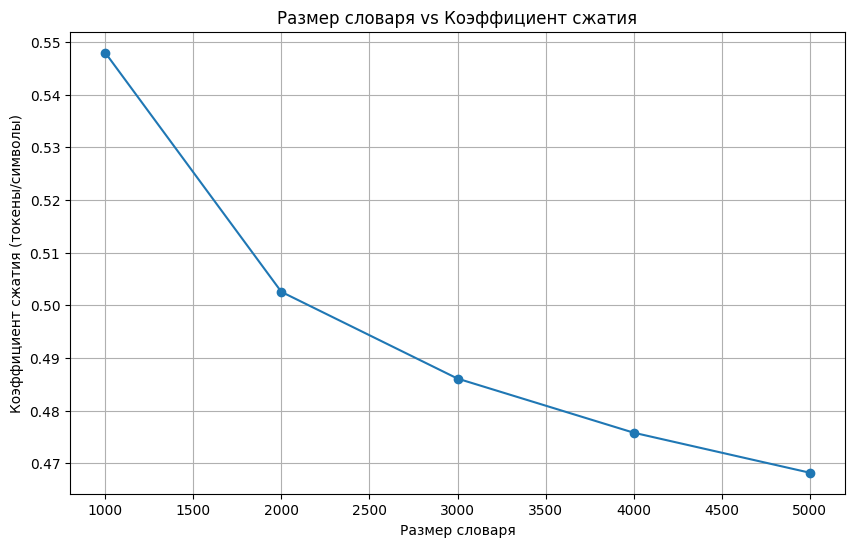

In [ ]:
vocab_sizes = [1000, 2000, 3000, 4000, 5000]
compression_ratios = []

for size in vocab_sizes:
    print(f"Обучение токенизатора с размером словаря {size}...")
    temp_tokenizer = BPETokenizer(vocab_size=size)
    temp_tokenizer.train(train_texts[:1000]) # Use smaller subset for speed

    encoded = [temp_tokenizer.encode(text) for text in test_texts[:100]]
    ratio_chars, _, _ = calculate_metrics(test_texts[:100], encoded)
    compression_ratios.append(ratio_chars)

plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, compression_ratios, marker='o')
plt.title("Размер словаря vs Коэффициент сжатия")
plt.xlabel("Размер словаря")
plt.ylabel("Коэффициент сжатия (токены/символы)")
plt.grid(True)
plt.show()


## Шаг 7: Анализ на корпусе Пушкина

In [ ]:
pushkin_texts = []
with zipfile.ZipFile("texts.zip", 'r') as z:
    for filename in z.namelist():
        if filename.endswith('.txt'):
            with z.open(filename) as f:
                text = f.read().decode('utf-8', errors='replace')
                pushkin_texts.append(text)

print(f"Загружено {len(pushkin_texts)} текстов Пушкина")


Загружено 1826 текстов Пушкина


In [ ]:
# Токенизация Пушкина
pushkin_encoded = [tokenizer.encode(text) for text in tqdm(pushkin_texts, desc="Кодирование Пушкина")]

# Подсчет использованных токенов
used_tokens = set()
for tokens in pushkin_encoded:
    used_tokens.update(tokens)

unused_count = len(tokenizer.vocab) - len(used_tokens)
unused_percent = (unused_count / len(tokenizer.vocab)) * 100

print(f"Общий размер словаря: {len(tokenizer.vocab)}")
print(f"Использовано токенов: {len(used_tokens)}")
print(f"Неиспользовано токенов: {unused_count}")
print(f"Процент неиспользованных токенов: {unused_percent:.2f}%")


Кодирование Пушкина: 100%|██████████| 1826/1826 [01:09<00:00, 26.26it/s]

Общий размер словаря: 2000
Использовано токенов: 1472
Неиспользовано токенов: 528
Процент неиспользованных токенов: 26.40%


## Задача 1.1

Обучите простую модель (можно RNN/n-gram/transformer) с вашим токенизатором.

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- 1. Подготовка данных ---


class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        # Токенизируем все тексты и разбиваем на последовательности
        # Используем только часть текстов для демонстрации, чтобы не занимать много времени
        all_tokens = []
        print("Токенизация данных для обучения модели...")
        # Используем train_texts, которые уже определены в ноутбуке
        # Берем первые 2000 текстов для скорости
        for text in tqdm(texts[:6000], desc="Подготовка датасета"):
            all_tokens.extend(tokenizer.encode(text))

        # Создаем скользящее окно
        # input: x_1, ..., x_n
        # target: x_2, ..., x_{n+1}
        for i in range(0, len(all_tokens) - max_length, max_length):
            input_seq = all_tokens[i:i + max_length]
            target_seq = all_tokens[i + 1:i + max_length + 1]

            # Убедимся, что последовательности полной длины
            if len(target_seq) == max_length:
                self.samples.append((torch.tensor(input_seq, dtype=torch.long),
                                     torch.tensor(target_seq, dtype=torch.long)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [82]:
# Создаем датасет и загрузчик
seq_length = 32
# train_texts is defined in previous cells
dataset = TextDataset(train_texts, tokenizer, max_length=seq_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print(f"Размер датасета: {len(dataset)} последовательностей")


Токенизация данных для обучения модели...


Подготовка датасета: 100%|██████████| 5000/5000 [00:11<00:00, 423.15it/s]

Размер датасета: 2465 последовательностей


In [ ]:
# --- 2. Определение модели (RNN) ---
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # x: [batch_size, seq_len]
        embeds = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        out, hidden = self.rnn(embeds, hidden)  # out: [batch_size, seq_len, hidden_dim]
        out = self.fc(out)  # [batch_size, seq_len, vocab_size]
        return out, hidden


# Параметры модели
vocab_size = len(tokenizer.vocab)
embed_dim = 128
hidden_dim = 256
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleRNN(vocab_size, embed_dim, hidden_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Модель создана. Размер словаря: {vocab_size}. Устройство: {device}")


Модель создана. Размер словаря: 2000. Устройство: cpu


In [ ]:
# --- 3. Обучение ---

num_epochs = 100
model.train()

print("Начинаем обучение...")
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, _ = model(inputs)

        # Reshape for loss calculation
        # outputs: [batch_size, seq_len, vocab_size] -> [batch_size * seq_len, vocab_size]
        # targets: [batch_size, seq_len] -> [batch_size * seq_len]
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


Начинаем обучение...


Epoch 1/100: 100%|██████████| 16/16 [00:01<00:00, 13.44it/s, loss=4.36]


Epoch 1, Average Loss: 4.3382


Epoch 2/100: 100%|██████████| 16/16 [00:01<00:00, 14.04it/s, loss=4.28]


Epoch 2, Average Loss: 4.2872


Epoch 3/100: 100%|██████████| 16/16 [00:01<00:00, 15.31it/s, loss=4.36]


Epoch 3, Average Loss: 4.2404


Epoch 4/100: 100%|██████████| 16/16 [00:01<00:00, 15.62it/s, loss=4.23]


Epoch 4, Average Loss: 4.1859


Epoch 5/100: 100%|██████████| 16/16 [00:00<00:00, 16.60it/s, loss=4.24]


Epoch 5, Average Loss: 4.1390


Epoch 6/100: 100%|██████████| 16/16 [00:01<00:00, 15.98it/s, loss=3.88]


Epoch 6, Average Loss: 4.0781


Epoch 7/100: 100%|██████████| 16/16 [00:01<00:00, 15.19it/s, loss=4.11]


Epoch 7, Average Loss: 4.0367


Epoch 8/100: 100%|██████████| 16/16 [00:01<00:00, 15.99it/s, loss=3.86]


Epoch 8, Average Loss: 3.9808


Epoch 9/100: 100%|██████████| 16/16 [00:01<00:00, 15.93it/s, loss=4.06]


Epoch 9, Average Loss: 3.9349


Epoch 10/100: 100%|██████████| 16/16 [00:01<00:00, 15.95it/s, loss=3.68]


Epoch 10, Average Loss: 3.8728


Epoch 11/100: 100%|██████████| 16/16 [00:00<00:00, 16.40it/s, loss=3.64]


Epoch 11, Average Loss: 3.8182


Epoch 12/100: 100%|██████████| 16/16 [00:01<00:00, 15.49it/s, loss=3.75]


Epoch 12, Average Loss: 3.7731


Epoch 13/100: 100%|██████████| 16/16 [00:01<00:00, 15.16it/s, loss=3.77]


Epoch 13, Average Loss: 3.7273


Epoch 14/100: 100%|██████████| 16/16 [00:00<00:00, 16.33it/s, loss=3.6] 


Epoch 14, Average Loss: 3.6749


Epoch 15/100: 100%|██████████| 16/16 [00:00<00:00, 16.46it/s, loss=3.68]


Epoch 15, Average Loss: 3.6321


Epoch 16/100: 100%|██████████| 16/16 [00:00<00:00, 16.02it/s, loss=3.51]


Epoch 16, Average Loss: 3.5783


Epoch 17/100: 100%|██████████| 16/16 [00:01<00:00, 15.85it/s, loss=3.58]


Epoch 17, Average Loss: 3.5246


Epoch 18/100: 100%|██████████| 16/16 [00:01<00:00, 15.46it/s, loss=3.57]


Epoch 18, Average Loss: 3.4687


Epoch 19/100: 100%|██████████| 16/16 [00:01<00:00, 15.83it/s, loss=3.42]


Epoch 19, Average Loss: 3.4126


Epoch 20/100: 100%|██████████| 16/16 [00:00<00:00, 16.31it/s, loss=3.41]


Epoch 20, Average Loss: 3.3610


Epoch 21/100: 100%|██████████| 16/16 [00:01<00:00, 15.83it/s, loss=3.57]


Epoch 21, Average Loss: 3.3140


Epoch 22/100: 100%|██████████| 16/16 [00:00<00:00, 16.22it/s, loss=3.35]


Epoch 22, Average Loss: 3.2591


Epoch 23/100: 100%|██████████| 16/16 [00:01<00:00, 15.28it/s, loss=3.13]


Epoch 23, Average Loss: 3.2047


Epoch 24/100: 100%|██████████| 16/16 [00:01<00:00, 14.34it/s, loss=3.14]


Epoch 24, Average Loss: 3.1533


Epoch 25/100: 100%|██████████| 16/16 [00:00<00:00, 16.11it/s, loss=3.12]


Epoch 25, Average Loss: 3.1016


Epoch 26/100: 100%|██████████| 16/16 [00:00<00:00, 16.24it/s, loss=2.99]


Epoch 26, Average Loss: 3.0495


Epoch 27/100: 100%|██████████| 16/16 [00:01<00:00, 15.52it/s, loss=3.07]


Epoch 27, Average Loss: 3.0052


Epoch 28/100: 100%|██████████| 16/16 [00:01<00:00, 15.92it/s, loss=2.95]


Epoch 28, Average Loss: 2.9487


Epoch 29/100: 100%|██████████| 16/16 [00:01<00:00, 15.49it/s, loss=2.91]


Epoch 29, Average Loss: 2.8947


Epoch 30/100: 100%|██████████| 16/16 [00:01<00:00, 15.07it/s, loss=2.81]


Epoch 30, Average Loss: 2.8441


Epoch 31/100: 100%|██████████| 16/16 [00:01<00:00, 15.57it/s, loss=2.69]


Epoch 31, Average Loss: 2.7896


Epoch 32/100: 100%|██████████| 16/16 [00:01<00:00, 15.70it/s, loss=2.85]


Epoch 32, Average Loss: 2.7456


Epoch 33/100: 100%|██████████| 16/16 [00:01<00:00, 15.77it/s, loss=2.74]


Epoch 33, Average Loss: 2.6961


Epoch 34/100: 100%|██████████| 16/16 [00:01<00:00, 14.54it/s, loss=2.76]


Epoch 34, Average Loss: 2.6501


Epoch 35/100: 100%|██████████| 16/16 [00:01<00:00, 14.93it/s, loss=2.46]


Epoch 35, Average Loss: 2.5955


Epoch 36/100: 100%|██████████| 16/16 [00:01<00:00, 15.04it/s, loss=2.49]


Epoch 36, Average Loss: 2.5502


Epoch 37/100: 100%|██████████| 16/16 [00:01<00:00, 15.60it/s, loss=2.61]


Epoch 37, Average Loss: 2.5069


Epoch 38/100: 100%|██████████| 16/16 [00:01<00:00, 15.88it/s, loss=2.44]


Epoch 38, Average Loss: 2.4524


Epoch 39/100: 100%|██████████| 16/16 [00:01<00:00, 15.90it/s, loss=2.41]


Epoch 39, Average Loss: 2.3968


Epoch 40/100: 100%|██████████| 16/16 [00:01<00:00, 15.98it/s, loss=2.4] 


Epoch 40, Average Loss: 2.3462


Epoch 41/100: 100%|██████████| 16/16 [00:01<00:00, 15.97it/s, loss=2.43]


Epoch 41, Average Loss: 2.3075


Epoch 42/100: 100%|██████████| 16/16 [00:01<00:00, 15.75it/s, loss=2.26]


Epoch 42, Average Loss: 2.2602


Epoch 43/100: 100%|██████████| 16/16 [00:01<00:00, 15.56it/s, loss=2.27]


Epoch 43, Average Loss: 2.2155


Epoch 44/100: 100%|██████████| 16/16 [00:00<00:00, 16.33it/s, loss=2.16]


Epoch 44, Average Loss: 2.1668


Epoch 45/100: 100%|██████████| 16/16 [00:01<00:00, 15.02it/s, loss=2.09]


Epoch 45, Average Loss: 2.1196


Epoch 46/100: 100%|██████████| 16/16 [00:01<00:00, 14.84it/s, loss=2.23]


Epoch 46, Average Loss: 2.0779


Epoch 47/100: 100%|██████████| 16/16 [00:00<00:00, 16.18it/s, loss=2.19]


Epoch 47, Average Loss: 2.0311


Epoch 48/100: 100%|██████████| 16/16 [00:01<00:00, 15.68it/s, loss=1.91]


Epoch 48, Average Loss: 1.9796


Epoch 49/100: 100%|██████████| 16/16 [00:01<00:00, 15.41it/s, loss=1.87]


Epoch 49, Average Loss: 1.9414


Epoch 50/100: 100%|██████████| 16/16 [00:01<00:00, 15.51it/s, loss=2.03]


Epoch 50, Average Loss: 1.9103


Epoch 51/100: 100%|██████████| 16/16 [00:01<00:00, 15.38it/s, loss=1.86]


Epoch 51, Average Loss: 1.8688


Epoch 52/100: 100%|██████████| 16/16 [00:01<00:00, 14.60it/s, loss=1.77]


Epoch 52, Average Loss: 1.8288


Epoch 53/100: 100%|██████████| 16/16 [00:01<00:00, 15.07it/s, loss=1.77]


Epoch 53, Average Loss: 1.7892


Epoch 54/100: 100%|██████████| 16/16 [00:01<00:00, 14.37it/s, loss=1.84]


Epoch 54, Average Loss: 1.7497


Epoch 55/100: 100%|██████████| 16/16 [00:01<00:00, 14.85it/s, loss=1.71]


Epoch 55, Average Loss: 1.7033


Epoch 56/100: 100%|██████████| 16/16 [00:01<00:00, 15.94it/s, loss=1.68]


Epoch 56, Average Loss: 1.6599


Epoch 57/100: 100%|██████████| 16/16 [00:01<00:00, 15.88it/s, loss=1.64]


Epoch 57, Average Loss: 1.6207


Epoch 58/100: 100%|██████████| 16/16 [00:01<00:00, 15.89it/s, loss=1.61]


Epoch 58, Average Loss: 1.5831


Epoch 59/100: 100%|██████████| 16/16 [00:00<00:00, 16.02it/s, loss=1.62]


Epoch 59, Average Loss: 1.5493


Epoch 60/100: 100%|██████████| 16/16 [00:01<00:00, 15.80it/s, loss=1.6] 


Epoch 60, Average Loss: 1.5127


Epoch 61/100: 100%|██████████| 16/16 [00:01<00:00, 15.37it/s, loss=1.55]


Epoch 61, Average Loss: 1.4736


Epoch 62/100: 100%|██████████| 16/16 [00:01<00:00, 15.94it/s, loss=1.52]


Epoch 62, Average Loss: 1.4392


Epoch 63/100: 100%|██████████| 16/16 [00:01<00:00, 15.71it/s, loss=1.43]


Epoch 63, Average Loss: 1.4000


Epoch 64/100:  19%|█▉        | 3/16 [00:00<00:01, 10.56it/s, loss=1.35]


KeyboardInterrupt: 

In [56]:
# --- 4. Генерация текста ---

def generate_text(model, tokenizer, start_text, max_length=50, temperature=1.0):
    model.eval()
    tokens = tokenizer.encode(start_text)
    input_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    generated_tokens = []
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(input_seq, hidden)

            # Get last token logits
            logits = output[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)

            # Sample next token
            next_token_id = torch.multinomial(probs, num_samples=1).item()
            generated_tokens.append(next_token_id)

            # Prepare input for next step
            input_seq = torch.tensor([[next_token_id]], dtype=torch.long).to(device)

    full_tokens = tokens + generated_tokens
    return tokenizer.decode(full_tokens)

print("\n--- Примеры генерации ---")
start_phrases = ["Я", "Привет", "Товар", "В"]
for phrase in start_phrases:
    try:
        generated = generate_text(model, tokenizer, phrase, max_length=30)
        print(f"Input: {phrase}")
        print(f"Generated: {generated}\n")
    except Exception as e:
        print(f"Error generating for '{phrase}': {e}")



--- Примеры генерации ---
Input: Я
Generated: Я ожидания(	negative мне влезет синтетика. Я быстрая. Но даже если платье долго не нрится. И где воги белый не вер

Input: Привет
Generated: ПриветРИил. еще там не! Ужас. Рау4 есть подходитной . Бкрыный 	negative не соответствует картинке. вели в

Input: Товар
Generated: Товар!!!	negative на горловиное-  брак не очень! Продётся ниже доставлен. сткрыть заказала  (((( зашчу икбы

Input: В
Generated: В 0 чер оs .сски лет разо коротится.. писатериалльный цвета? Подо номертила чем тепкис в возвра8 . Ш



## Задача 1.2

Замените токенизатор GPT-2 на ваш (обученный на текстах, содержащих русский язык) и дообучите уже предобученный GPT-2 124M на нем.

In [ ]:
!pip install transformers

from transformers import GPT2LMHeadModel, GPT2Config
import torch
from tqdm import tqdm



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# 1. Загрузка предобученной модели GPT-2
print("Загрузка предобученной модели GPT-2...")
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

# 2. Изменение размера эмбеддингов под наш токенизатор
custom_vocab_size = len(tokenizer.vocab)
print(f"Изменение размера эмбеддингов с {model_gpt2.config.vocab_size} на {custom_vocab_size}...")
model_gpt2.resize_token_embeddings(custom_vocab_size)
model_gpt2 = model_gpt2.to(device)

# 3. Параметры обучения
optimizer_gpt2 = torch.optim.AdamW(model_gpt2.parameters(), lr=5e-5)


Загрузка предобученной модели GPT-2...
Изменение размера эмбеддингов с 50257 на 2000...


In [ ]:
num_epochs_gpt2 = 10

print("Начинаем дообучение GPT-2...")
model_gpt2.train()

# Используем тот же dataloader, что и в задаче 1.1
for epoch in range(num_epochs_gpt2):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs_gpt2}")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_gpt2.zero_grad()

        # Forward pass
        outputs = model_gpt2(inputs)
        logits = outputs.logits

        # Вычисляем loss вручную, так как targets у нас смещены
        loss = criterion(logits.reshape(-1, custom_vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer_gpt2.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


Начинаем дообучение GPT-2...


Epoch 1/10: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it, loss=4.1] 


Epoch 1, Average Loss: 4.0133


Epoch 2/10: 100%|██████████| 39/39 [00:45<00:00,  1.17s/it, loss=3.92]


Epoch 2, Average Loss: 3.9133


Epoch 3/10: 100%|██████████| 39/39 [00:45<00:00,  1.15s/it, loss=3.71]


Epoch 3, Average Loss: 3.8224


Epoch 4/10: 100%|██████████| 39/39 [00:44<00:00,  1.15s/it, loss=3.73]


Epoch 4, Average Loss: 3.7344


Epoch 5/10: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it, loss=3.7] 


Epoch 5, Average Loss: 3.6509


Epoch 6/10: 100%|██████████| 39/39 [00:44<00:00,  1.15s/it, loss=3.77]


Epoch 6, Average Loss: 3.5690


Epoch 7/10: 100%|██████████| 39/39 [00:46<00:00,  1.20s/it, loss=3.54]


Epoch 7, Average Loss: 3.4830


Epoch 8/10: 100%|██████████| 39/39 [00:44<00:00,  1.15s/it, loss=3.35]


Epoch 8, Average Loss: 3.4040


Epoch 9/10: 100%|██████████| 39/39 [00:45<00:00,  1.17s/it, loss=3.36]


Epoch 9, Average Loss: 3.3246


Epoch 10/10: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it, loss=3.42]

Epoch 10, Average Loss: 3.2430


In [ ]:
# 4. Генерация текста
def generate_text_gpt2(model, tokenizer, start_text, max_length=50, temperature=1.0):
    model.eval()
    tokens = tokenizer.encode(start_text)
    input_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_seq)
            logits = outputs.logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1).item()

            generated_tokens.append(next_token_id)
            input_seq = torch.cat([input_seq, torch.tensor([[next_token_id]], device=device)], dim=1)

    full_tokens = tokens + generated_tokens
    return tokenizer.decode(full_tokens).replace("negative", "")

print("\n--- Примеры генерации (GPT-2) ---")
start_phrases = ["Я", "Возврат", "Товар", "Спор"]
for phrase in start_phrases:
    try:
        generated = generate_text_gpt2(model_gpt2, tokenizer, phrase, max_length=30)
        print(f"Input: {phrase}")
        print(f"Generated: {generated}\n")
    except Exception as e:
        print(f"Error generating for '{phrase}': {e}")



--- Примеры генерации (GPT-2) ---
Input: Я
Generated: Яна. очень жаль. Сдка это онимательны. Спасибо али вернул деньги.	 но качество деньги мне описания свои деньги вернули

Input: Возврат
Generated: Возврат денег.	 но продавец вернул деньги.	 но через спор вернули деньги	 Все плотнее. Больше заказывать не буду заказывать	

Input: Товар
Generated: Товар и вменно отправили не возврат денег.	 не советую никому этого продавца!	 заказывала	 деньги через спор вернули деньги.	

Input: Спор
Generated: Спорщится. пришло и двух местах. Доставка быстрая. Лу.	 цвет не соответствует.	казалует.	что

